<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"></ul></div>

Prepare depth image sample to  

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
K = np.array([[400, 0, 960], 
              [0, 400, 540], 
              [0, 0, 1]])
K_inv =  np.array([[1 / K[0, 0], 0, -K[0, 2] / K[0, 0]], 
                   [0, 1 / K[1, 1], -K[1, 2] / K[1, 1]], 
                   [0, 0, 1]])
img_size = (1080, 1920)
camera_pose = np.array([0, 0, 1.5])
camera_roll = np.pi / 18
camera_rotation = np.array([[1, 0, 0], 
                            [0, np.cos(camera_roll), -np.sin(camera_roll)], 
                            [0, np.sin(camera_roll), np.cos(camera_roll)]])
optical2base = np.array([[0, 0, 1], 
                         [-1, 0, 0],  
                         [0, -1, 0]])

max_depth = 40

def transform_cam2base_ray(pt):
    return optical2base @ camera_rotation.T @ K_inv @ pt 

In [3]:
result_depth_image = np.zeros(img_size, dtype=np.uint16)

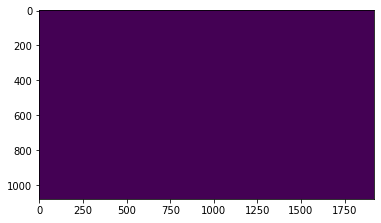

In [4]:
plt.imshow(result_depth_image)

# Sidewalk

In [5]:
sidewalk_height = 0.15 # GOST sidewalk height is 15 cm
road_half_width = 2 * 3.75

sidewalk_depth_image = np.zeros(img_size, dtype=np.uint16)

def left_sidewalk_check(pt):
    return (pt[1] > road_half_width)

def right_sidewalk_check(pt):
    return (pt[1] < -road_half_width)

for i in range(img_size[0]):
    for j in range(img_size[1]):
        ray = transform_cam2base_ray(np.array([j, i, 1.]))
        depth = (camera_pose[2] - sidewalk_height) / (-ray[2])
        base_pt = camera_pose + ray * depth
        if not left_sidewalk_check(base_pt):
            break
        if depth > max_depth or depth < 0:
            continue
        sidewalk_depth_image[i, j] = round(depth * 1000)
        
    for j in range(img_size[1] -1, -1, -1):
        ray = transform_cam2base_ray(np.array([j, i, 1.]))
        depth = (camera_pose[2] - sidewalk_height) / (-ray[2])
        base_pt = camera_pose + ray * depth
        if not right_sidewalk_check(base_pt):
            break
        if depth > max_depth or depth < 0:
            continue
        sidewalk_depth_image [i, j] = round(depth * 1000)

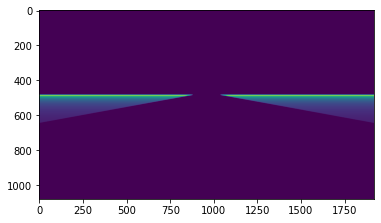

In [6]:
plt.imshow(sidewalk_depth_image)

# Road

In [7]:
def road_check(pt):
    return (np.abs(pt[1]) < 2 * 3.75)

road_depth_image = np.zeros(img_size, dtype=np.uint16)

for i in range(img_size[0]):
    for j in range(img_size[1]):
        ray = transform_cam2base_ray(np.array([j, i, 1.]))
        depth = (camera_pose[2]) / (-ray[2])
        base_pt = camera_pose + ray * depth
        if not road_check(base_pt) or depth > max_depth or depth < 0:
            continue
        road_depth_image[i, j] = round(depth * 1000)

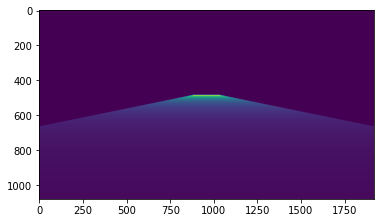

In [8]:
plt.imshow(road_depth_image)

# Road edges

In [9]:
def edge_check(pt):
    if (pt[2] > sidewalk_height):
        return 1
    if (pt[2] < 0):
        return -1
    return 0

edges_depth_image = np.zeros(img_size, dtype=np.uint16)

for j in range(img_size[1]):
    for i in range(img_size[0] -1, -1, -1):
        ray = transform_cam2base_ray(np.array([j, i, 1.]))
        depth = road_half_width / np.abs(ray[1])
        base_pt = camera_pose + ray * depth
        road_check_res = edge_check(base_pt)
        if road_check_res == -1 or depth > max_depth or depth < 0:
            continue
        if road_check_res == 1:
            break
        edges_depth_image[i, j] = round(depth * 1000)

/home/mikhail/.local/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in double_scalars
  del sys.path[0]
/home/mikhail/.local/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in multiply
  


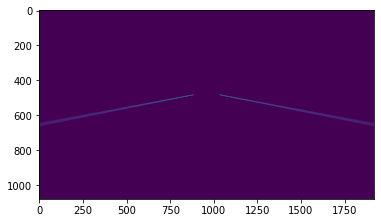

In [10]:
plt.imshow(edges_depth_image)

# Bridge

In [11]:
bridge_angle = np.arctan2(20, 100) 
bridge_norm_vector = np.array([np.cos(bridge_angle), 0, -np.sin(bridge_angle)])
bridge_distance  = 3
bridge_height = 3
def bridge_check(pt):
    return (np.abs(pt[1]) < 3.75) and (pt[2] < bridge_height) and (pt[2] > 0)

bridge_depth_image = np.zeros(img_size, dtype=np.uint16)

for i in range(img_size[0]):
    for j in range(img_size[1]):
        ray = transform_cam2base_ray(np.array([j, i, 1.]))
        depth = bridge_distance / bridge_norm_vector.dot(ray)
        base_pt = camera_pose + ray * depth
        if not bridge_check(base_pt) or depth > max_depth or depth < 0:
            continue
        bridge_depth_image[i, j] = round(depth * 1000)

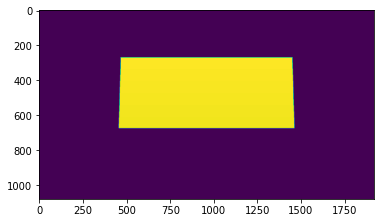

In [12]:
plt.imshow(bridge_depth_image)

# Unite

In [13]:
result_depth_image = np.copy(road_depth_image)
result_depth_image[edges_depth_image > 0] = edges_depth_image[edges_depth_image > 0]
result_depth_image[sidewalk_depth_image > 0] = sidewalk_depth_image[sidewalk_depth_image > 0]
result_depth_image[bridge_depth_image > 0] = bridge_depth_image[bridge_depth_image > 0]

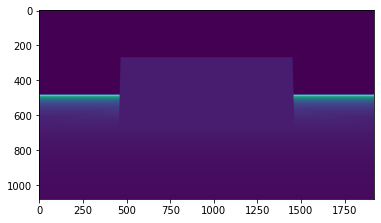

In [14]:
plt.imshow(result_depth_image )

# Save

In [15]:
import cv2
cv2.imwrite("../Data/depth_sample.png", result_depth_image)

True

In [17]:
np.savetxt("../Data/K", K)